# Model Evaluation and Comparison

This notebook is used to evaluate and compare the performance of different models on the test set. We will test the following models:
1. DenseNet
2. DenseNetSE
3. EfficientNet
4. ResNet
5. ViT-Base
6. Traditional machine learning methods

For each model, we will calculate the following metrics:
- Accuracy
- Precision
- Recall
- F1-Score

Finally, we will summarize all results in a table for comparison.

In [1]:
import os
import sys
from tqdm.notebook import tqdm
import seaborn as sns
import gc
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timm
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torchvision import models
from tqdm.notebook import tqdm

# Add project root directory to system path
sys.path.append('..')

# Import custom dataset
from dataset import create_dataloaders

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cuda


## 1. Load Test Dataset

Use the create_dataloaders function from dataset.py to load the test dataset.

In [2]:
# Set data path
data_root = '../Aerial_Landscapes'

# Load test dataset
_, _, test_loader, classes = create_dataloaders(
    root_dir=data_root,
    batch_size=128,
    split_ratio=[0.6, 0.2, 0.2],
    augmentation_strategy='default',
    num_workers=0,
    verbose=True
)

print(f"Classes: {classes}")
print(f"Test set size: {len(test_loader.dataset)}")

Creating data loaders, batch_size=128, split_ratio=[0.6, 0.2, 0.2], augmentation=default...
Dataset size - Train: 7200, Validation: 2400, Test: 2400
Training set class distribution:
- Agriculture: 480 images
- Airport: 480 images
- Beach: 480 images
- City: 480 images
- Desert: 480 images
- Forest: 480 images
- Grassland: 480 images
- Highway: 480 images
- Lake: 480 images
- Mountain: 480 images
- Parking: 480 images
- Port: 480 images
- Railway: 480 images
- Residential: 480 images
- River: 480 images
Classes: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']
Test set size: 2400


## 2. Define Evaluation Functions

Create a generic evaluation function to calculate model performance metrics.

In [3]:
def evaluate_model(model, test_loader, device, model_name):
    """Evaluate model performance and return metrics
    
    Parameters:
    model: The model to evaluate
    test_loader: Test data loader
    device: Computation device
    model_name: Model name for saving results
    
    Returns:
    dict: Dictionary containing various metrics
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Save prediction results
    results = {
        'true_labels': all_labels,
        'pred_labels': all_preds
    }
    
    # Create save directory
    os.makedirs('results', exist_ok=True)
    
    # Save results
    np.save(f'results/{model_name}_predictions.npy', results)
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8),dpi=100)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.savefig(f'results/{model_name}_confusion_matrix.png')
    plt.close()
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
def evaluate_traditional_model(classifier, test_loader, model_name, feature_method='HOG'):
    """Evaluate traditional machine learning model performance

    Parameters:
    classifier: The classifier model (SVM or KNN)
    test_loader: Test data loader
    model_name: Model name for saving results
    feature_method: Feature extraction method ('HOG' or 'LBP')

    Returns:
    dict: Dictionary containing various metrics
    """
    # Import these here to ensure they are available
    import torchvision.transforms.functional as TF

    # Load pre-trained model
    model_path = f'models/{model_name.lower()}.joblib'
    if os.path.exists(model_path):
        classifier = joblib.load(model_path)
        print(f"Loaded pre-trained model: {model_path}")
    else:
        print(f"Warning: Could not find pre-trained model: {model_path}")
        return None

    # Collect test data
    test_images = []
    all_labels = []

    for images, labels in tqdm(test_loader, desc=f"Preparing {model_name} test data"):
        # Convert images to grayscale numpy arrays
        for img, label in zip(images, labels):
            img_pil = TF.to_pil_image(img).convert("L")
            img_np = np.array(img_pil)
            test_images.append(img_np)
            all_labels.append(label.item())

    # Feature extraction
    print(f"Extracting {feature_method} features...")
    X_test = extract_features(test_images, method=feature_method)
    y_test = np.array(all_labels)

    # Predict
    print(f"Making predictions with {model_name}...")
    y_pred = classifier.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Save prediction results
    results = {
        'true_labels': y_test,
        'pred_labels': y_pred
    }

    # Create save directory
    os.makedirs('results', exist_ok=True)

    # Save results
    np.save(f'results/{model_name}_predictions.npy', results)

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8),dpi=100)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.savefig(f'results/{model_name}_confusion_matrix.png')
    plt.close()

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Define feature extraction functions
def extract_features(images, method='HOG'):
    """Extract HOG or LBP features from images

    Parameters:
    images: List of images
    method: 'HOG' or 'LBP'

    Returns:
    np.array: Array of features
    """
    from skimage.feature import hog, local_binary_pattern

    features = []
    for img in tqdm(images, desc=f"Extracting {method} features"):
        if method == 'HOG':
            feat = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), feature_vector=True)
        elif method == 'LBP':
            lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 59))
            feat = hist / np.sum(hist)
        features.append(feat)
    return np.array(features)

## 3. Evaluate Each Model


### 3.1 Evaluate DenseNet Model

In [4]:
# Load DenseNet model
densenet_model = models.densenet121(pretrained=False)
densenet_model.classifier = torch.nn.Linear(1024, len(classes))

# Load trained weights
densenet_path = 'models/densenet.pth'
if os.path.exists(densenet_path):
    densenet_model.load_state_dict(torch.load(densenet_path))
    print(f"Loaded DenseNet model weights: {densenet_path}")
else:
    print(f"Warning: Could not find DenseNet model weights: {densenet_path}")

# Move model to device
densenet_model = densenet_model.to(device)

# Evaluate model
densenet_results = evaluate_model(densenet_model, test_loader, device, 'DenseNet')
print(f"DenseNet evaluation results: {densenet_results}")

# Release memory
del densenet_model
torch.cuda.empty_cache()
gc.collect()

D:\develop\miniconda3\envs\torchgpu3132\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\develop\miniconda3\envs\torchgpu3132\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded DenseNet model weights: models/densenet.pth


Evaluating DenseNet:   0%|          | 0/19 [00:00<?, ?it/s]

DenseNet evaluation results: {'model_name': 'DenseNet', 'accuracy': 0.9525, 'precision': 0.9540262316553038, 'recall': 0.9525, 'f1_score': 0.9523205478033432}


8

### 3.2 Evaluate DenseNetSE Model

In [5]:
# Define SE Block
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=8):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.BatchNorm1d(channel // reduction),
            nn.SiLU(),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# Define DenseNet121-SE model
def densenet121_se(num_classes, reduction=8):
    base = models.densenet121(pretrained=True)
    feat = base.features; cls_layer = base.classifier
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.stem = nn.Sequential(*list(feat.children())[:4])
            self.block1, self.trans1 = feat.denseblock1, feat.transition1
            self.block2, self.trans2 = feat.denseblock2, feat.transition2
            self.block3, self.trans3 = feat.denseblock3, feat.transition3
            self.block4 = feat.denseblock4; self.norm5 = feat.norm5
            self.se1 = SEBlock(256, reduction)
            self.se2 = SEBlock(512, reduction)
            self.se3 = SEBlock(1024, reduction)
            self.se4 = SEBlock(1024, reduction)
            self.classifier = nn.Linear(1024, num_classes)
        def forward(self, x):
            x = self.stem(x)
            x = self.block1(x); x = self.se1(x); x = self.trans1(x)
            x = self.block2(x); x = self.se2(x); x = self.trans2(x)
            x = self.block3(x); x = self.se3(x); x = self.trans3(x)
            x = self.block4(x); x = self.se4(x)
            x = self.norm5(x)
            x = nn.functional.adaptive_avg_pool2d(x, (1,1)).view(x.size(0),-1)
            return self.classifier(x)
    return Net()

# Load DenseNetSE model with correct structure
densenetse_model = densenet121_se(num_classes=len(classes))

# Check both possible locations for trained weights
densenetse_path = 'models/densenet_se.pth'
saved_models_path = '../DenseNet/saved_models_se/best_se.pth'

if os.path.exists(densenetse_path):
    densenetse_model.load_state_dict(torch.load(densenetse_path))
    print(f"Loaded DenseNetSE model weights: {densenetse_path}")
elif os.path.exists(saved_models_path):
    densenetse_model.load_state_dict(torch.load(saved_models_path))
    print(f"Loaded DenseNetSE model weights from training directory: {saved_models_path}")
else:
    print(f"Warning: Could not find DenseNetSE model weights")

# Move model to device
densenetse_model = densenetse_model.to(device)

# Evaluate model
densenetse_results = evaluate_model(densenetse_model, test_loader, device, 'DenseNetSE')
print(f"DenseNetSE evaluation results: {densenetse_results}")

# Release memory
del densenetse_model
torch.cuda.empty_cache()
gc.collect()

D:\develop\miniconda3\envs\torchgpu3132\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\develop\miniconda3\envs\torchgpu3132\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loaded DenseNetSE model weights: models/densenet_se.pth


Evaluating DenseNetSE:   0%|          | 0/19 [00:00<?, ?it/s]

DenseNetSE evaluation results: {'model_name': 'DenseNetSE', 'accuracy': 0.9720833333333333, 'precision': 0.9726046959573512, 'recall': 0.9720833333333333, 'f1_score': 0.9720523088987633}


25715

### 3.3 Evaluate EfficientNet Model

In [6]:
# Load EfficientNet model
efficientnet_model = models.efficientnet_b0(pretrained=False)
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, len(classes))

# Load trained weights
possible_paths = [
    'models/efficientnet.pt',
    'models/efficientnet.pth',
    '../EfficientNet/models/best_model.pt',
    '../EfficientNet/models/efficientnet.pt'
]

weights_loaded = False
for path in possible_paths:
    if os.path.exists(path):
        efficientnet_model.load_state_dict(torch.load(path, map_location=device))
        print(f"Loaded EfficientNet model weights: {path}")
        weights_loaded = True
        break

if not weights_loaded:
    print(f"Warning: Could not find EfficientNet model weights. Checked paths: {possible_paths}")

# Move model to device
efficientnet_model = efficientnet_model.to(device)

# Evaluate model
efficientnet_results = evaluate_model(efficientnet_model, test_loader, device, 'EfficientNet')
print(f"EfficientNet evaluation results: {efficientnet_results}")

# Release memory
del efficientnet_model
torch.cuda.empty_cache()
gc.collect()

D:\develop\miniconda3\envs\torchgpu3132\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\develop\miniconda3\envs\torchgpu3132\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded EfficientNet model weights: models/efficientnet.pt


Evaluating EfficientNet:   0%|          | 0/19 [00:00<?, ?it/s]

EfficientNet evaluation results: {'model_name': 'EfficientNet', 'accuracy': 0.96125, 'precision': 0.9622975134856817, 'recall': 0.96125, 'f1_score': 0.9611797169862727}


18933

### 3.4 Evaluate ResNet Model

In [7]:
# Load ResNet model
resnet_model = models.resnet18(pretrained=False)
resnet_model.fc = torch.nn.Linear(512, len(classes))

# Load trained weights
resnet_path = 'models/resnet.pth'
if os.path.exists(resnet_path):
    resnet_model.load_state_dict(torch.load(resnet_path))
    print(f"Loaded ResNet model weights: {resnet_path}")
else:
    print(f"Warning: Could not find ResNet model weights: {resnet_path}")

# Move model to device
resnet_model = resnet_model.to(device)

# Evaluate model
resnet_results = evaluate_model(resnet_model, test_loader, device, 'ResNet')
print(f"ResNet evaluation results: {resnet_results}")

# Release memory
del resnet_model
torch.cuda.empty_cache()
gc.collect()

Loaded ResNet model weights: models/resnet.pth


D:\develop\miniconda3\envs\torchgpu3132\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\develop\miniconda3\envs\torchgpu3132\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Evaluating ResNet:   0%|          | 0/19 [00:00<?, ?it/s]

ResNet evaluation results: {'model_name': 'ResNet', 'accuracy': 0.9525, 'precision': 0.9541304242893031, 'recall': 0.9525, 'f1_score': 0.9526409783053057}


18933

### 3.5 Evaluate ViT-Base Model

In [8]:
# Load ViT-Base model
vit_model = timm.create_model('vit_base_patch16_224', pretrained=False)
in_features = vit_model.head.in_features
vit_model.head = torch.nn.Sequential(
    torch.nn.Linear(in_features, 512),
    torch.nn.BatchNorm1d(512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, len(classes))
)

# Load trained weights
vit_path = 'models/vit_base.pth'
if os.path.exists(vit_path):
    vit_model.load_state_dict(torch.load(vit_path))
    print(f"Loaded ViT-Base model weights: {vit_path}")
else:
    print(f"Warning: Could not find ViT-Base model weights: {vit_path}")

# Move model to device
vit_model = vit_model.to(device)

# Evaluate model
vit_results = evaluate_model(vit_model, test_loader, device, 'ViT-Base')
print(f"ViT-Base evaluation results: {vit_results}")

# Release memory
del vit_model
torch.cuda.empty_cache()
gc.collect()

Loaded ViT-Base model weights: models/vit_base.pth


Evaluating ViT-Base:   0%|          | 0/19 [00:00<?, ?it/s]

ViT-Base evaluation results: {'model_name': 'ViT-Base', 'accuracy': 0.9629166666666666, 'precision': 0.9645918422755322, 'recall': 0.9629166666666666, 'f1_score': 0.9630980527815161}


18925

### 3.6 Evaluate Traditional Machine Learning Models

In [9]:
# Import required libraries for traditional methods
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Create traditional models
print("Loading pre-trained traditional models...")
traditional_models = {
    'HOG_SVM': SVC(kernel='linear'),
    'HOG_KNN': KNeighborsClassifier(n_neighbors=5),
    'LBP_SVM': SVC(kernel='linear'),
    'LBP_KNN': KNeighborsClassifier(n_neighbors=5)
}

# Evaluate models
traditional_results = []

# Evaluate HOG + SVM model
hog_svm_results = evaluate_traditional_model(
    traditional_models['HOG_SVM'], 
    test_loader, 
    'HOG_SVM', 
    feature_method='HOG'
)
if hog_svm_results is not None:
    traditional_results.append(hog_svm_results)
    print(f"HOG + SVM evaluation results: {hog_svm_results}")

# Evaluate HOG + KNN model
hog_knn_results = evaluate_traditional_model(
    traditional_models['HOG_KNN'], 
    test_loader, 
    'HOG_KNN', 
    feature_method='HOG'
)
if hog_knn_results is not None:
    traditional_results.append(hog_knn_results)
    print(f"HOG + KNN evaluation results: {hog_knn_results}")

# Evaluate LBP + SVM model
lbp_svm_results = evaluate_traditional_model(
    traditional_models['LBP_SVM'], 
    test_loader, 
    'LBP_SVM', 
    feature_method='LBP'
)
if lbp_svm_results is not None:
    traditional_results.append(lbp_svm_results)
    print(f"LBP + SVM evaluation results: {lbp_svm_results}")

# Evaluate LBP + KNN model
lbp_knn_results = evaluate_traditional_model(
    traditional_models['LBP_KNN'], 
    test_loader, 
    'LBP_KNN', 
    feature_method='LBP'
)
if lbp_knn_results is not None:
    traditional_results.append(lbp_knn_results)
    print(f"LBP + KNN evaluation results: {lbp_knn_results}")

# Release memory
gc.collect()

Loading pre-trained traditional models...
Loaded pre-trained model: models/hog_svm.joblib


Preparing HOG_SVM test data:   0%|          | 0/19 [00:00<?, ?it/s]

Extracting HOG features...


Extracting HOG features:   0%|          | 0/2400 [00:00<?, ?it/s]

Making predictions with HOG_SVM...
HOG + SVM evaluation results: {'model_name': 'HOG_SVM', 'accuracy': 0.3095833333333333, 'precision': 0.3042233762472853, 'recall': 0.3095833333333333, 'f1_score': 0.3033091342127459}
Loaded pre-trained model: models/hog_knn.joblib


Preparing HOG_KNN test data:   0%|          | 0/19 [00:00<?, ?it/s]

Extracting HOG features...


Extracting HOG features:   0%|          | 0/2400 [00:00<?, ?it/s]

Making predictions with HOG_KNN...


D:\develop\miniconda3\envs\torchgpu3132\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


HOG + KNN evaluation results: {'model_name': 'HOG_KNN', 'accuracy': 0.11625, 'precision': 0.3865167851685533, 'recall': 0.11625, 'f1_score': 0.07936366935843985}
Loaded pre-trained model: models/lbp_svm.joblib


Preparing LBP_SVM test data:   0%|          | 0/19 [00:00<?, ?it/s]

Extracting LBP features...


Extracting LBP features:   0%|          | 0/2400 [00:00<?, ?it/s]

Making predictions with LBP_SVM...


D:\develop\miniconda3\envs\torchgpu3132\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LBP + SVM evaluation results: {'model_name': 'LBP_SVM', 'accuracy': 0.1825, 'precision': 0.24242229964959375, 'recall': 0.1825, 'f1_score': 0.13027730818017952}
Loaded pre-trained model: models/lbp_knn.joblib


Preparing LBP_KNN test data:   0%|          | 0/19 [00:00<?, ?it/s]

Extracting LBP features...


Extracting LBP features:   0%|          | 0/2400 [00:00<?, ?it/s]

Making predictions with LBP_KNN...
LBP + KNN evaluation results: {'model_name': 'LBP_KNN', 'accuracy': 0.37375, 'precision': 0.3851516536077845, 'recall': 0.37375, 'f1_score': 0.37216356872125683}


18938

## 4. Summarize Results

Compile all model evaluation results into a table and visualize the comparison.

Model evaluation results summary:


,accuracy,precision,recall,f1_score
model_name,,,,
DenseNet,0.952500,0.954026,0.952500,0.952321
DenseNetSE,0.972083,0.972605,0.972083,0.972052
EfficientNet,0.961250,0.962298,0.961250,0.961180
ResNet,0.952500,0.954130,0.952500,0.952641
ViT-Base,0.962917,0.964592,0.962917,0.963098
HOG_SVM,0.309583,0.304223,0.309583,0.303309
HOG_KNN,0.116250,0.386517,0.116250,0.079364
LBP_SVM,0.182500,0.242422,0.182500,0.130277
LBP_KNN,0.373750,0.385152,0.373750,0.372164


<Figure size 1400x1000 with 0 Axes>

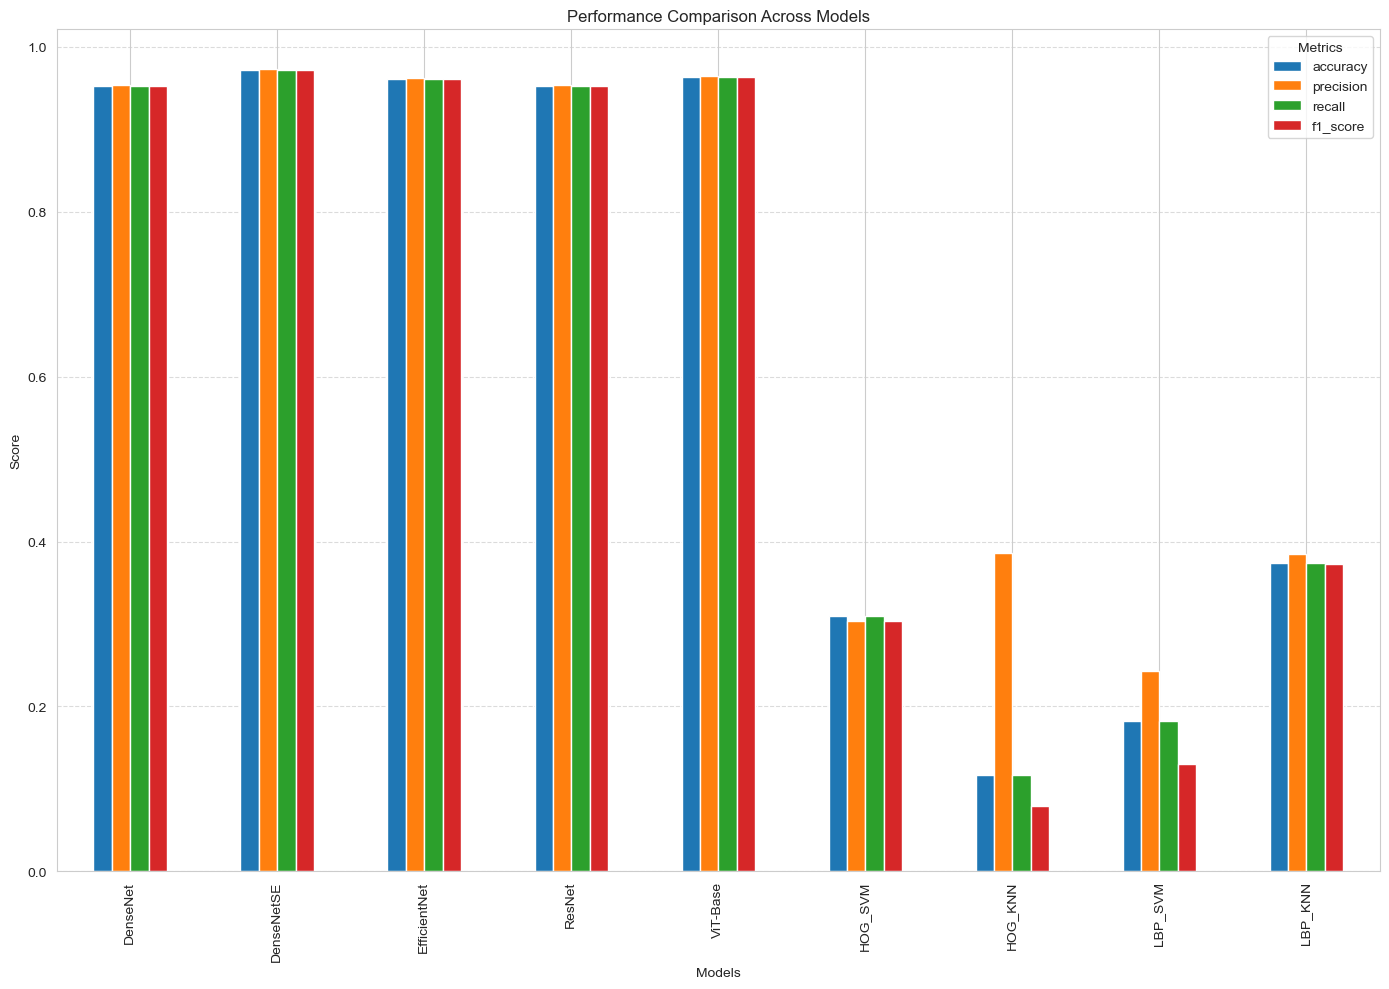

In [10]:
# Summarize all results
all_results = [
    densenet_results,
    densenetse_results,
    efficientnet_results,
    resnet_results,
    vit_results,
] + traditional_results  # Add all traditional model results

# Create DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.set_index('model_name')

# Display results table
print("Model evaluation results summary:")
display(results_df)

# Save results to CSV file
results_df.to_csv('results/model_comparison.csv')

# Visualize comparison
plt.figure(figsize=(14, 10),dpi=100)
results_df.plot(kind='bar', figsize=(14, 10))
plt.title('Performance Comparison Across Models')
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend(title='Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('results/model_comparison.png')
plt.show()

<Figure size 1400x1000 with 0 Axes>

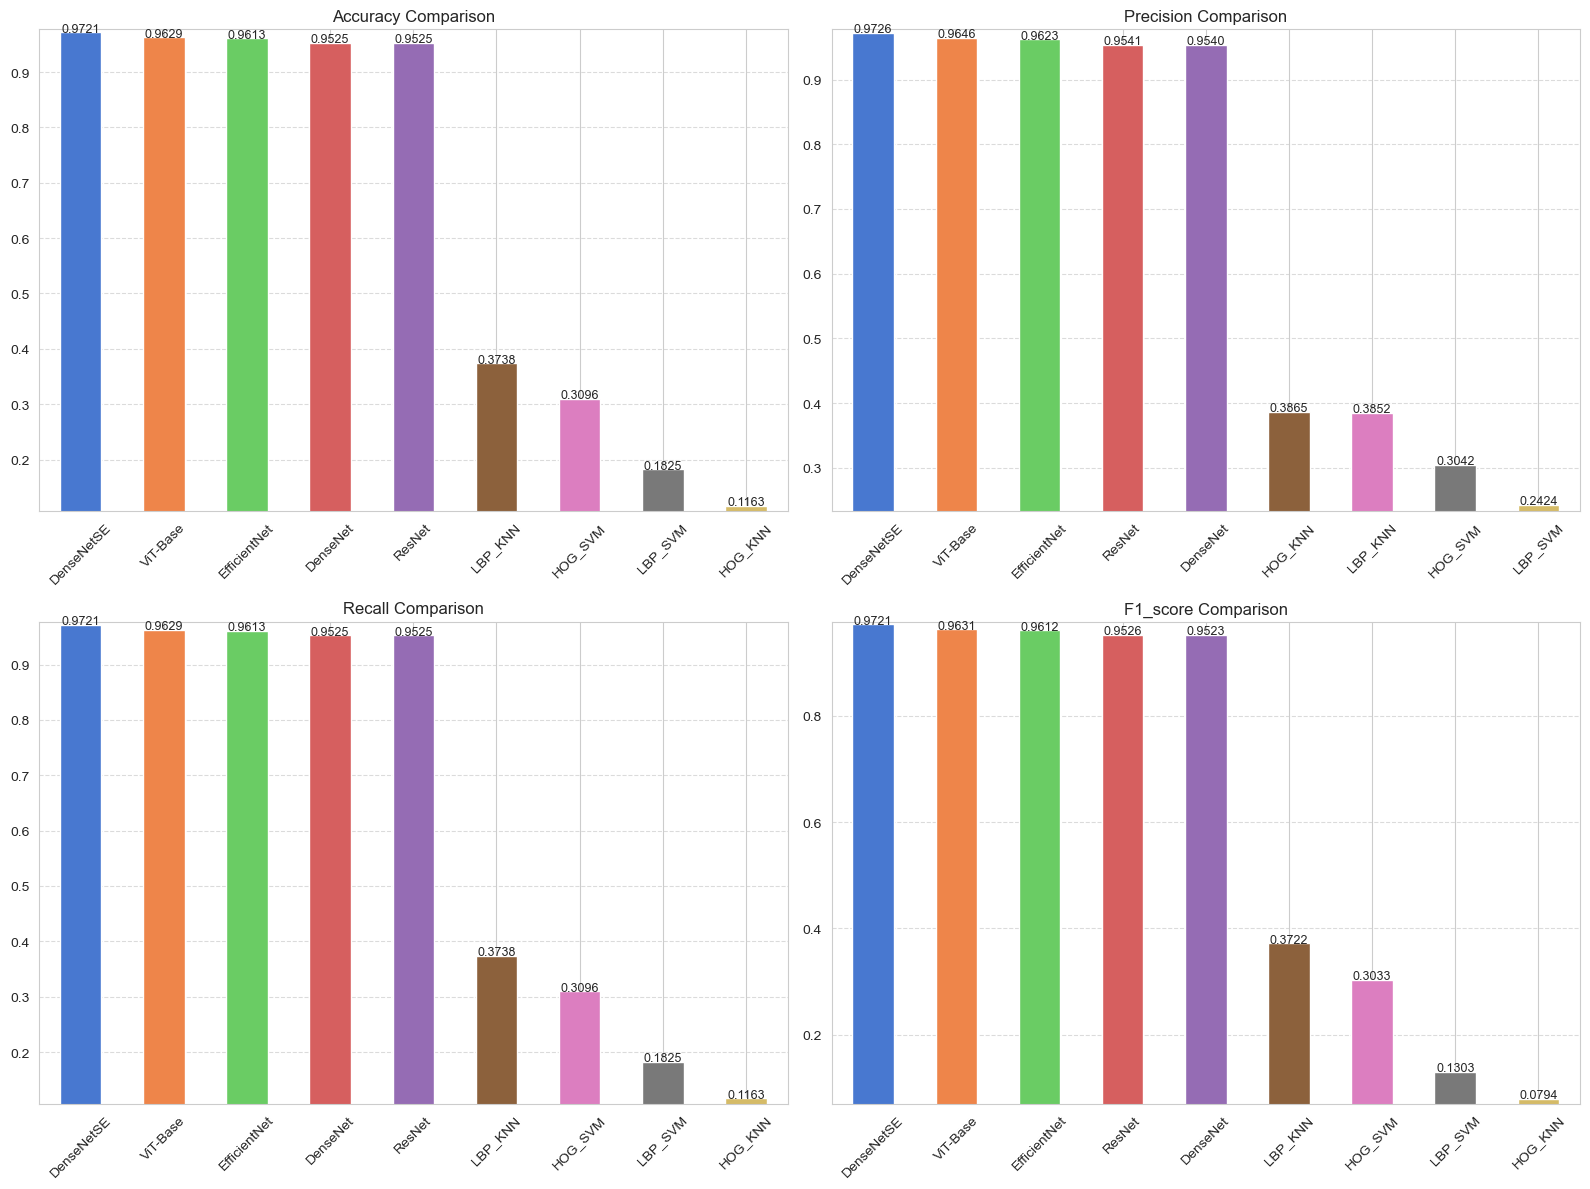

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Set the Y-axis starting point to amplify differences
plt.figure(figsize=(14, 10),dpi=100)

# Find the minimum value for each metric as Y-axis starting point (with a slight margin)
min_values = results_df.min() - 0.01
max_values = results_df.max() + 0.005

# Create four subplots, each displaying one metric
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metrics = ['accuracy', 'precision', 'recall', 'f1_score']
for i, metric in enumerate(metrics):
    ax = axes[i]
    # Sort and plot to make rankings more intuitive
    sorted_df = results_df.sort_values(by=metric, ascending=False)
    bars = sorted_df[metric].plot(kind='bar', ax=ax, color=sns.color_palette("muted", len(sorted_df)))

    # Display specific values at the top of each bar
    for bar in bars.patches:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.4f}', ha='center', fontsize=9)

    # Set Y-axis range to amplify differences
    ax.set_ylim(min_values[metric], max_values[metric])

    # Add grid lines for better comparison
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Set titles and labels
    ax.set_title(f'{metric.capitalize()} Comparison', fontsize=12)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('results/improved_model_comparison.png', dpi=300)


## 5. GradCAM Visualization Comparison

In this section, we will compare the GradCAM visualizations for different models on the same test images. This helps us understand how different models focus on different parts of the images when making predictions.

Loading models for GradCAM visualization...


D:\develop\miniconda3\envs\torchgpu3132\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\develop\miniconda3\envs\torchgpu3132\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
D:\develop\miniconda3\envs\torchgpu3132\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Running GradCAM comparison for all models...


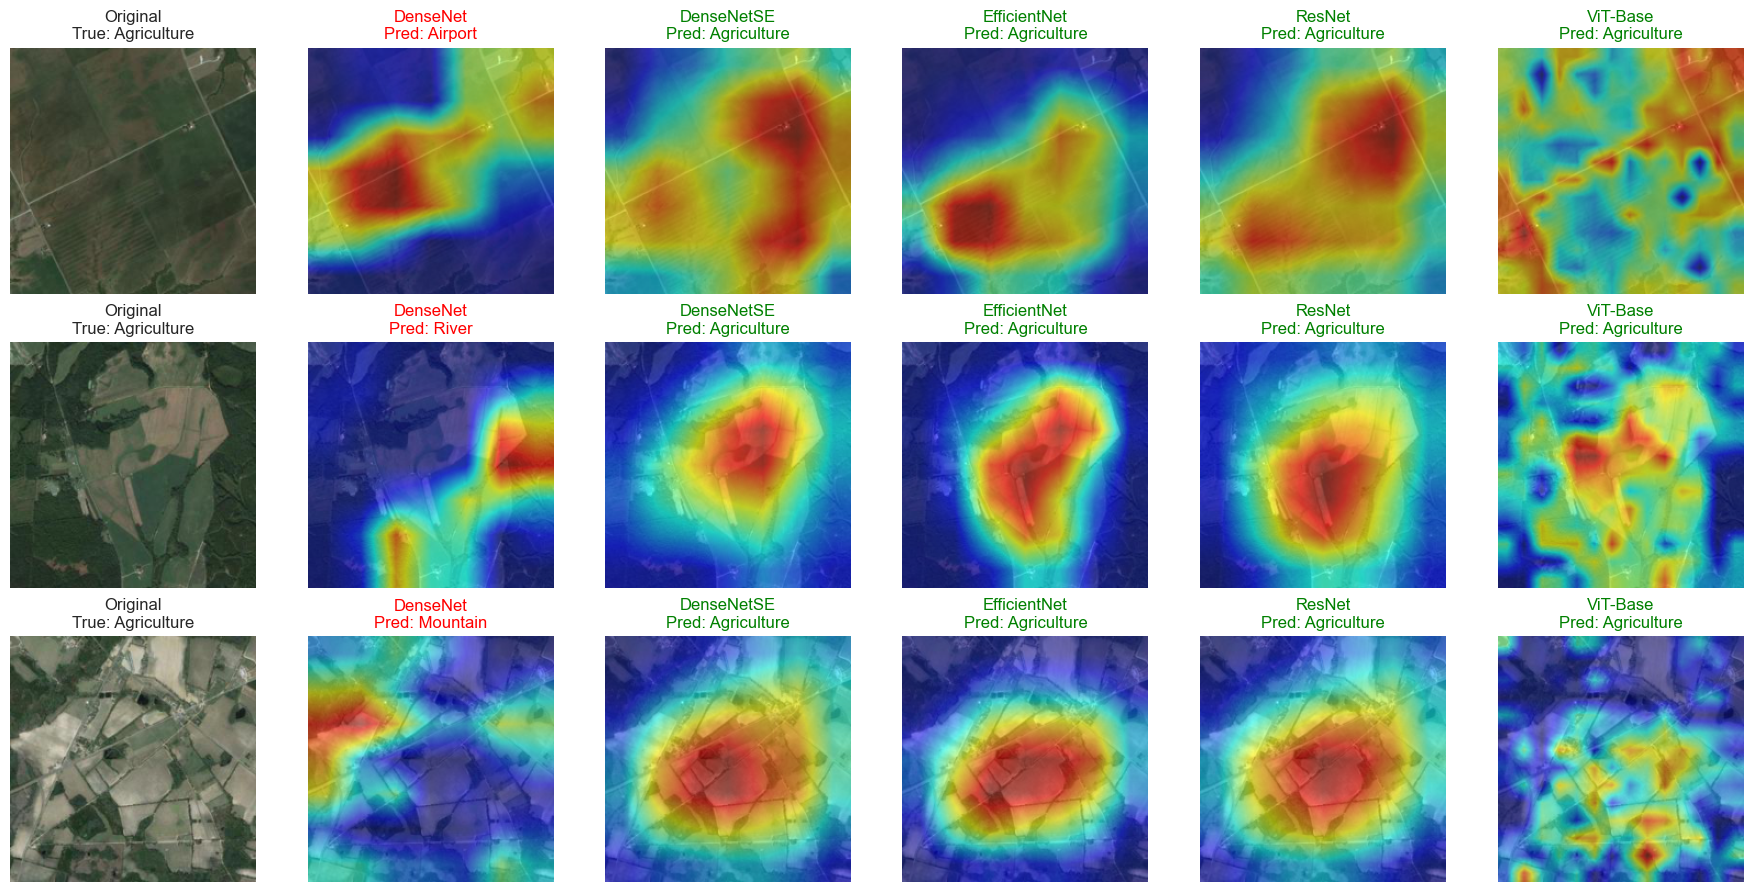

GradCAM comparison visualization has been saved as 'results/models_gradcam_comparison.png'


111468

In [12]:
# Import GradCAM related libraries
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.reshape_transforms import vit_reshape_transform


def compare_models_gradcam(models, model_names, test_loader, classes, num_images=10):
    """
    Compare GradCAM visualizations for multiple models on the same test images.
    Only visualize samples where at least one model makes an incorrect prediction.

    Parameters:
    models: List of models to compare
    model_names: List of model names
    test_loader: Test data loader
    classes: Class names
    num_images: Number of images to visualize
    """
    # Collect all test images and labels
    all_images = []
    all_labels = []
    for images, labels in test_loader:
        all_images.extend(images)
        all_labels.extend(labels)

    # Identify misclassified samples
    misclassified_indices = []
    for idx, (img_tensor, true_label) in enumerate(zip(all_images, all_labels)):
        for model, model_name in zip(models, model_names):
            model = model.to(device)
            model.eval()
            with torch.no_grad():
                outputs = model(img_tensor.unsqueeze(0).to(device))
                _, pred = torch.max(outputs, 1)
                if pred.item() != true_label.item():
                    misclassified_indices.append(idx)
                    break  # Only need one model to misclassify

    # Limit to the specified number of images
    misclassified_indices = misclassified_indices[:num_images]
    test_images = [all_images[i] for i in misclassified_indices]
    test_labels = [all_labels[i].item() for i in misclassified_indices]

    # Define target layers for each model
    target_layers_dict = {
        'DenseNet': lambda model: [model.features.denseblock4.denselayer16.conv2],
        'DenseNetSE': lambda model: [model.se4],
        'EfficientNet': lambda model: [model.features[-1]],
        'ResNet': lambda model: [model.layer4[-1]],
        'ViT-Base': lambda model: [model.blocks[-1].norm1]
    }

    # Determine if reshape_transform is needed (only for ViT)
    reshape_transform_dict = {
        'ViT-Base': vit_reshape_transform,
        'DenseNet': None,
        'DenseNetSE': None,
        'EfficientNet': None,
        'ResNet': None
    }

    # Create figure with one row per image and one column per model plus original
    fig, axes = plt.subplots(len(test_images), len(models) + 1,
                             figsize=(3 * (len(models) + 1), 3 * len(test_images)))

    # For each test image
    for img_idx, (img_tensor, true_label) in enumerate(zip(test_images, test_labels)):
        # Display original image in the first column
        img = img_tensor.cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        # Handle both single and multi-row cases
        if len(test_images) > 1:
            ax = axes[img_idx, 0]
        else:
            ax = axes[0]

        ax.imshow(img)
        ax.set_title(f"Original\nTrue: {classes[true_label]}")
        ax.axis('off')

        # For each model
        for model_idx, (model, model_name) in enumerate(zip(models, model_names)):
            model = model.to(device)
            model.eval()

            # Get predictions
            with torch.no_grad():
                outputs = model(img_tensor.unsqueeze(0).to(device))
                _, pred = torch.max(outputs, 1)
                pred_label = pred.item()

            # Set up GradCAM
            target_layers = target_layers_dict[model_name](model)
            reshape_transform = reshape_transform_dict[model_name]

            cam = GradCAM(
                model=model,
                target_layers=target_layers,
                reshape_transform=reshape_transform
            )

            # Generate GradCAM
            targets = [ClassifierOutputTarget(pred_label)]
            grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0).to(device), targets=targets)
            grayscale_cam = grayscale_cam[0, :]

            # Apply heatmap to image
            visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

            # Display the GradCAM visualization
            if len(test_images) > 1:
                ax = axes[img_idx, model_idx + 1]
            else:
                ax = axes[model_idx + 1]

            ax.imshow(visualization)
            title = f"{model_name}\nPred: {classes[pred_label]}"
            if pred_label == true_label:
                color = 'green'
            else:
                color = 'red'
            ax.set_title(title, color=color)
            ax.axis('off')

    plt.tight_layout()
    plt.savefig('results/models_gradcam_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"GradCAM comparison visualization has been saved as 'results/models_gradcam_comparison.png'")

# Reload all models for visualization
print("Loading models for GradCAM visualization...")

# Load DenseNet model
densenet_model = models.densenet121(pretrained=False)
densenet_model.classifier = torch.nn.Linear(1024, len(classes))
densenet_model.load_state_dict(torch.load('models/densenet.pth'))
densenet_model = densenet_model.to(device)

# Load DenseNetSE model
densenetse_model = densenet121_se(num_classes=len(classes))
densenetse_model.load_state_dict(torch.load('models/densenet_se.pth'))
densenetse_model = densenetse_model.to(device)

# Load EfficientNet model
efficientnet_model = models.efficientnet_b0(pretrained=False)
efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, len(classes))
efficientnet_model.load_state_dict(torch.load('models/efficientnet.pt', map_location=device))
efficientnet_model = efficientnet_model.to(device)

# Load ResNet model
resnet_model = models.resnet18(pretrained=False)
resnet_model.fc = torch.nn.Linear(512, len(classes))
resnet_model.load_state_dict(torch.load('models/resnet.pth'))
resnet_model = resnet_model.to(device)

# Load ViT-Base model
vit_model = timm.create_model('vit_base_patch16_224', pretrained=False)
vit_model.head = torch.nn.Sequential(
    torch.nn.Linear(vit_model.head.in_features, 512),
    torch.nn.BatchNorm1d(512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(512, len(classes))
)
vit_model.load_state_dict(torch.load('models/vit_base.pth'))
vit_model = vit_model.to(device)

# Run GradCAM comparison on all models
models_list = [densenet_model, densenetse_model, efficientnet_model, resnet_model, vit_model]
model_names = ['DenseNet', 'DenseNetSE', 'EfficientNet', 'ResNet', 'ViT-Base']

print("Running GradCAM comparison for all models...")
compare_models_gradcam(models_list, model_names, test_loader, classes, num_images=3)

# Cleanup memory
for model in models_list:
    del model
torch.cuda.empty_cache()
gc.collect()
